In [1]:
import matplotlib.pyplot as plt
import aiohttp
import numpy as np
from ardac_utils import *

In [2]:
#use helper function to get community locations as gdf
#and native corp polygons as gdf
places_gdf = get_point_gdf_by_category("communities")
nc_gdf = get_area_gdf_by_category("corporations")

UnsupportedGEOSVersionError: 'from_geojson' requires at least GEOS 3.10.1.

In [ ]:
#limit to only US places
places_gdf = places_gdf[places_gdf['country'] == 'US'].copy()

In [ ]:
nc_gdf

,id,name,the_geom
0,NC1,"Ahtna, Incorporated","MULTIPOLYGON (((-144.17464 63.11695, -143.7954..."
0,NC2,Arctic Slope Regional Corporation,"MULTIPOLYGON (((-163.73179 68.20790, -163.7327..."
0,NC3,Bering Straits Native Corporation,"MULTIPOLYGON (((-165.00286 66.99931, -164.4635..."
0,NC4,Bristol Bay Native Corporation,"MULTIPOLYGON (((-153.65698 59.99936, -153.6569..."
0,NC5,Calista Corporation,"MULTIPOLYGON (((-180.00000 57.99874, -180.0000..."
0,NC6,Chugach Alaska Corporation,"MULTIPOLYGON (((-147.74473 61.33961, -147.2066..."
0,NC7,"Cook Inlet Region, Incorporated","MULTIPOLYGON (((-153.32637 58.91286, -153.6946..."
0,NC8,"Doyon, Limited","MULTIPOLYGON (((-143.90935 68.95851, -143.6712..."
0,NC9,"Koniag, Incorporated","MULTIPOLYGON (((-153.32637 58.91286, -153.3162..."
0,NC10,NANA Regional Corporation,"MULTIPOLYGON (((-163.73179 68.20790, -163.7277..."


In [ ]:
#and perform a spatial join for all communities inside of nc boundaries
results = gpd.sjoin(nc_gdf, places_gdf, how='left', predicate="contains").reset_index().dropna()
results

,index,id_left,name_left,the_geom,index_right,id_right,name_right,country,latitude,longitude
0,0,NC1,"Ahtna, Incorporated","MULTIPOLYGON (((-144.17464 63.11695, -143.7954...",239,AK240,McCarthy,US,61.4333,-142.922
1,0,NC1,"Ahtna, Incorporated","MULTIPOLYGON (((-144.17464 63.11695, -143.7954...",67,AK73,Chitina,US,61.5158,-144.437
2,0,NC1,"Ahtna, Incorporated","MULTIPOLYGON (((-144.17464 63.11695, -143.7954...",231,AK232,Lower Tonsina,US,61.655,-144.659
3,0,NC1,"Ahtna, Incorporated","MULTIPOLYGON (((-144.17464 63.11695, -143.7954...",402,AK403,Tonsina,US,61.6558,-145.175
4,0,NC1,"Ahtna, Incorporated","MULTIPOLYGON (((-144.17464 63.11695, -143.7954...",191,AK189,Kenny Lake,US,61.7379,-144.945
...,...,...,...,...,...,...,...,...,...,...
519,0,NC12,The Aleut Corporation,"MULTIPOLYGON (((-180.00000 49.99844, -180.0000...",15,AK18,Angoon,US,57.5033,-134.584
520,0,NC12,The Aleut Corporation,"MULTIPOLYGON (((-180.00000 49.99844, -180.0000...",54,AK60,Chatham,US,57.514,-134.924
521,0,NC12,The Aleut Corporation,"MULTIPOLYGON (((-180.00000 49.99844, -180.0000...",390,AK392,Tenakee Springs,US,57.7808,-135.219
522,0,NC12,The Aleut Corporation,"MULTIPOLYGON (((-180.00000 49.99844, -180.0000...",368,AK460,Stan Price State Wildlife Sanctuary,US,57.9051,-134.275


In [ ]:
#using the community lat lons, get heating degree days for each community in the results table from SNAP Data API
#add a check for error codes in the response
#use decades 2020-2030, 2030-2040, and 2040-2050 and calculate the mean heating degree days over each decade
#write the attributes to the results dataframe
decades = [['2020', '2030'], ['2030', '2040'], ['2040', '2050']]
decades_cols = ['heating_dd_2020-2030','heating_dd_2030-2040','heating_dd_2040-2050']
for new_col_name in decades_cols:
    results[new_col_name] = None

async with aiohttp.ClientSession() as s:
    for index, row in results.iterrows():
        lat = row.latitude
        lon = row.longitude
        for d, c in zip(decades,decades_cols):
            url = str('https://earthmaps.io/degree_days/heating/' + str(lat) + "/" + str(lon) + "/" + d[0] + "/" + d[1] + "?summarize=mmm")
            async with s.get(url) as response:
                if response.status != 200:
                    print("no data returned for " + row['name_right'] + ": " + str(lat) + ", " + str(lon))
                else:
                    dd_json = await response.json()
                    dd_mean = dd_json['projected']['ddmean']
                    results.iloc[index, results.columns.get_loc(c)] = dd_mean

no data returned for Kaktovik: 70.1131, -143.6623
no data returned for Kaktovik: 70.1131, -143.6623
no data returned for Kaktovik: 70.1131, -143.6623
no data returned for King Island: 64.9694, -168.065
no data returned for King Island: 64.9694, -168.065
no data returned for King Island: 64.9694, -168.065
no data returned for Diomede: 65.7648, -168.911
no data returned for Diomede: 65.7648, -168.911
no data returned for Diomede: 65.7648, -168.911
no data returned for Chiniak: 57.617, -152.2166
no data returned for Chiniak: 57.617, -152.2166
no data returned for Chiniak: 57.617, -152.2166
no data returned for Port Alexander: 56.2497, -134.644
no data returned for Port Alexander: 56.2497, -134.644
no data returned for Port Alexander: 56.2497, -134.644
no data returned for Chiniak: 57.617, -152.2166
no data returned for Chiniak: 57.617, -152.2166
no data returned for Chiniak: 57.617, -152.2166
no data returned for Port Alexander: 56.2497, -134.644
no data returned for Port Alexander: 56.24

In [ ]:
results

,index,id_left,name_left,the_geom,index_right,id_right,name_right,country,latitude,longitude,heating_dd_2020-2030,heating_dd_2030-2040,heating_dd_2040-2050
0,0,NC1,"Ahtna, Incorporated","MULTIPOLYGON (((-144.17464 63.11695, -143.7954...",239,AK240,McCarthy,US,61.4333,-142.922,12895,12707,11992
1,0,NC1,"Ahtna, Incorporated","MULTIPOLYGON (((-144.17464 63.11695, -143.7954...",67,AK73,Chitina,US,61.5158,-144.437,12660,12444,11679
2,0,NC1,"Ahtna, Incorporated","MULTIPOLYGON (((-144.17464 63.11695, -143.7954...",231,AK232,Lower Tonsina,US,61.655,-144.659,12311,12075,11310
3,0,NC1,"Ahtna, Incorporated","MULTIPOLYGON (((-144.17464 63.11695, -143.7954...",402,AK403,Tonsina,US,61.6558,-145.175,12419,12183,11381
4,0,NC1,"Ahtna, Incorporated","MULTIPOLYGON (((-144.17464 63.11695, -143.7954...",191,AK189,Kenny Lake,US,61.7379,-144.945,12311,12075,11310
...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,0,NC12,The Aleut Corporation,"MULTIPOLYGON (((-180.00000 49.99844, -180.0000...",15,AK18,Angoon,US,57.5033,-134.584,7793,7786,7096
520,0,NC12,The Aleut Corporation,"MULTIPOLYGON (((-180.00000 49.99844, -180.0000...",54,AK60,Chatham,US,57.514,-134.924,6469,6509,5894
521,0,NC12,The Aleut Corporation,"MULTIPOLYGON (((-180.00000 49.99844, -180.0000...",390,AK392,Tenakee Springs,US,57.7808,-135.219,8109,8057,7350
522,0,NC12,The Aleut Corporation,"MULTIPOLYGON (((-180.00000 49.99844, -180.0000...",368,AK460,Stan Price State Wildlife Sanctuary,US,57.9051,-134.275,6927,6938,6296


In [ ]:
#groupby native corp and get the mean of heating degree days for each decade
#then plot
nc_dd_mean = results.groupby('name_left', as_index=False)[['heating_dd_2020-2030', 'heating_dd_2030-2040', 'heating_dd_2040-2050']].mean()
nc_dd_mean

,name_left,heating_dd_2020-2030,heating_dd_2030-2040,heating_dd_2040-2050
0,"Ahtna, Incorporated",13410.47619,13159.190476,12380.47619
1,Arctic Slope Regional Corporation,15988.454545,15260.090909,14031.727273
2,Bering Straits Native Corporation,12727.952381,12305.333333,11220.47619
3,Bristol Bay Native Corporation,9597.189189,9402.621622,8487.540541
4,Calista Corporation,10274.368852,10065.680328,9120.418033
5,Chugach Alaska Corporation,9792.464286,9717.607143,8969.107143
6,"Cook Inlet Region, Incorporated",10470.5,10323.12963,9456.537037
7,"Doyon, Limited",13154.311111,12771.0,11835.3
8,"Koniag, Incorporated",8509.75,8412.0,7714.25
9,NANA Regional Corporation,13861.384615,13335.230769,12319.692308


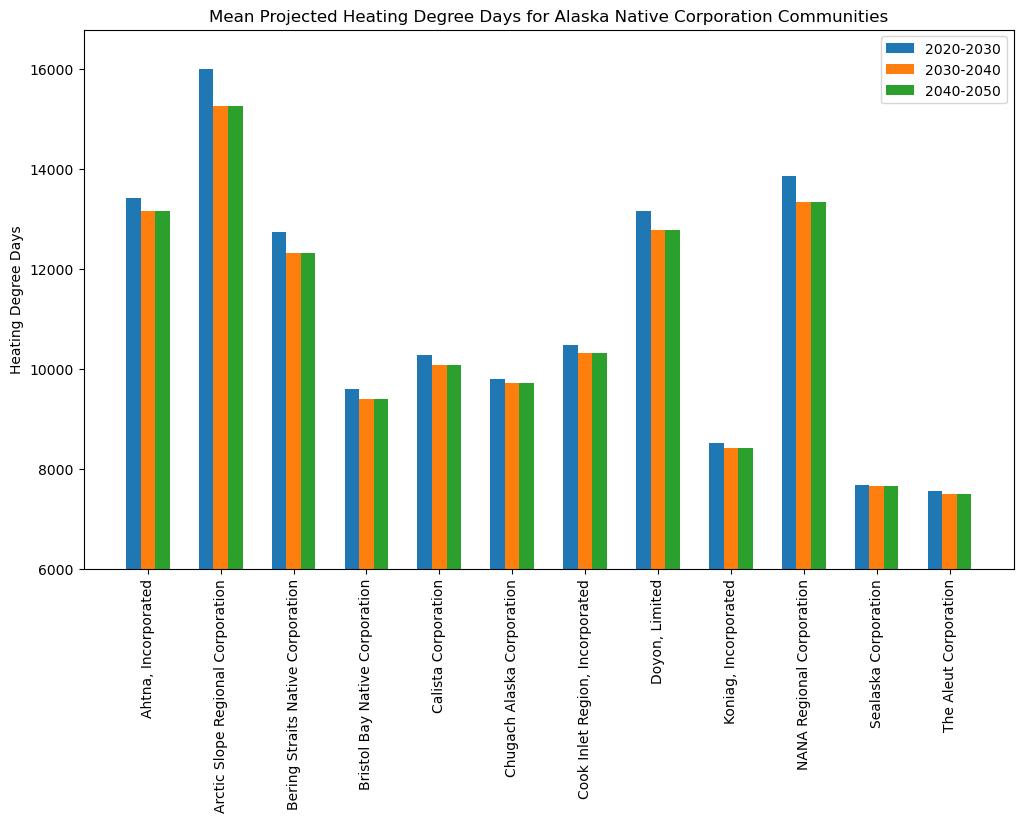

In [ ]:
x = nc_dd_mean["name_left"]
y1 = nc_dd_mean["heating_dd_2020-2030"]
y2 = nc_dd_mean["heating_dd_2030-2040"]
y3 = nc_dd_mean["heating_dd_2040-2050"]
  
x_axis = np.arange(len(x))

plt.figure(figsize=(12,7)) 

plt.bar(x_axis - 0.2, y1, 0.2, label = '2020-2030') 
plt.bar(x_axis + 0.0, y2, 0.2, label = '2030-2040')
plt.bar(x_axis + 0.2, y2, 0.2, label = '2040-2050') 
  
plt.xticks(x_axis, x, rotation='vertical') 
#plt.xlabel("Alaska Native Corporation") 
plt.ylim(ymin=6000)
plt.ylabel("Heating Degree Days") 
plt.title("Mean Projected Heating Degree Days for Alaska Native Corporation Communities") 
plt.legend() 
plt.show() 